# SSD TRAINING AND TESTING (TUTORIAL)
In this tutorial, we will show how to initialize, train and test an SSD300 for object detection.
The tutorial is based on a subset of pictures from the PascalVOC dataset (both 2007 and 2012).

### IMPORTS
We start by importing all the necessary functions.

In [1]:
import torch
from PIL import Image
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms

from smithers.ml.vgg import VGG
from smithers.ml.models.aux_conv import AuxiliaryConvolutions
from smithers.ml.models.predictor import PredictionConvolutions
from smithers.ml.dataset.pascalvoc_dataset import PascalVOCDataset
from smithers.ml.models.detector import Detector
from smithers.ml.models.utils import create_prior_boxes


import warnings
warnings.filterwarnings("ignore")

### LEARNING PARAMETERS
Then, we set the parameters used for the data, the detector and the learning phase.

In [2]:
# Learning parameters
batch_size = 8  # batch size
workers = 4  # number of workers for loading data in the DataLoader
iterations = 120000  # number of iterations to train
print_freq = 200  # print training status every __ batches
lr = 1e-4  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1
# decay learning rate to this fraction of the existing learning rate
#n_classes = 6
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None
# clip if gradients are exploding, which may happen at larger batch sizes

#voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat',
#        'bottle', 'bus', 'car', 'cat', 'chair',
#        'cow', 'diningtable', 'dog', 'horse',
#        'motorbike', 'person', 'pottedplant',
#        'sheep', 'sofa', 'train', 'tvmonitor')
voc_labels = ('cat', 'dog')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
n_classes = len(label_map)
print('categories:',label_map)
print('n_classes:', n_classes)

categories: {'cat': 1, 'dog': 2, 'background': 0}
n_classes: 3


### DATA PARAMETERS
We now define the train and test images, after they have been extracted and the subdivision has been carried out (refer to the data preparation tutorial for more details).

In [3]:
# Data parameters
data_folder = 'VOC_dog_cat/JSONfiles' #folder with json data files
keep_difficult = True


train_dataset = PascalVOCDataset(data_folder,
                                 split='train',
                                 keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_dataset.collate_fn,
    num_workers=workers,
    pin_memory=True)

epochs = iterations // (len(train_dataset) // 16) #500
decay_lr_at = [it // (len(train_dataset) // 16) for it in decay_lr_at]
print('Training images:', len(train_dataset))


test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=test_dataset.collate_fn,
                                          num_workers=workers,
                                          pin_memory=True)
print('Testing images:', len(test_dataset))


Training images: 240
Testing images: 60


### NETWORK INITIALIZATION
The following cell contains the lines used to instantiate the detector object.

In [4]:
start_init = time()
base_net = VGG(classifier='ssd', init_weights=False)
aux_conv = AuxiliaryConvolutions()
predictor = PredictionConvolutions(n_classes)
network = [base_net, aux_conv, predictor]
priors_cxcy = create_prior_boxes()
end_init = time()
print(f'Time needed to initialize the net: {round(end_init-start_init,2)} seconds')


Loaded base model.

Time needed to initialize the net: 1.79 seconds


### NETWORK TRAINING/LOADING A CHECKPOINT, TESTING THE NETWORK
Here, the network will trained and, if provided, a checkpoint can be used to start from an already trained network.
It is possible to choose a different number for the ``epochs`` variable (obviously, choosing a low number will not produce satisfactory results).
The cell also prints the time spans needed to perform some operations and prints the final model, moreover pieces of information specific to the different epochs are generated at each iteration.

The training procedure will store a checkpoint file named ``checkpoint_ssd300.pth.tar``, once it is completed.
Furthermore, the plot of the value of the loss against the corresponding epoch is produced.

[VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

Evaluating: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


{'cat': 0.09745939821004868, 'dog': 0.12730325758457184}
{'cat': 0.09745939821004868, 'dog': 0.12730325758457184}

Mean Average Precision (mAP): 0.112
Time needed for testing the net: 10.63 seconds, i.e. 0.2 minutes


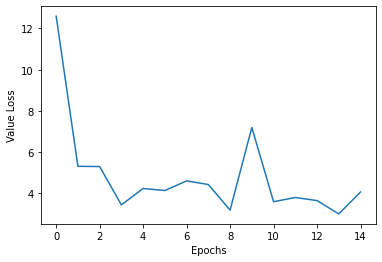

In [5]:
check = None # if no checkpoint available
#check = 'checkpoint_ssd300.pth.tar' #if a checkpoint is available
#check = 'Results/2000_full/checkpoint_ssd300.pth.tar'
epochs = 15
start = time()
detector = Detector(network, check, priors_cxcy, n_classes, epochs,
                        batch_size, print_freq, lr, decay_lr_at,
                        decay_lr_to, momentum, weight_decay, grad_clip,
                        train_loader, test_loader)
print(detector.model)
checkpoint, loss_values, mAP_values = detector.train_detector_with_eval(label_map)
end = time()
print(f'Time needed for training the net: {round(end-start,2)} seconds, i.e. {round((end-start)/60,1)} minutes')
start_test = time()
epo = np.arange(start=0, stop=epochs, step=1)
plt.plot(epo, loss_values)
plt.xlabel('Epochs')
plt.ylabel('Value Loss')
plt.savefig('loss_pascal_cat.png')
detector.eval_detector(label_map, checkpoint)
end_test = time()

print(f'Time needed for testing the net: {round(end_test-start_test,2)} seconds, i.e. {round((end_test-start_test)/60,1)} minutes')

### TESTING WITH AN IMAGE + PRINT
By choosing a specific image from the directory used, the network is able to detect the object(s) in it and save a version of the image in which the bounding box(es) with the relative label(s) is(/are) pictured. To view this, open the file ``out.jpg``.

In [15]:
img_path = '/u/s/szanin/Smithers/smithers/ml/tutorials/VOC_dog_cat/JPEGImages/001239.jpg'
#img_path = 'voc_dir/VOC_cat-dog/JPEGImages/001239.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

detector.detect(original_image,
                checkpoint,
                label_map,
                min_score=0.01,
                max_overlap=0.45,
                top_k=3).show()